# SIS with constant beta 

In [1]:
from gekko import GEKKO 
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

In [2]:
def sis(t,i,beta,gamma):
    return beta*(1-i)*i-gamma*i 
m=GEKKO()
nt=500
i0=0.01
beta_list=[0.3,1]
gamma=0.1
b=15
tf=10
u_max=1
time=np.linspace(0,tf,nt)
X_control=np.zeros((len(beta_list),time.shape[0]))
X_normal=np.zeros((len(beta_list),time.shape[0]))
U=np.zeros((len(beta_list),time.shape[0]))
for index,beta in enumerate(beta_list):
    print(beta)
    m.time=time

    x1=m.Var(value=i0,lb=0,ub=1)
    x2=m.Var(value=0)
    u=m.Var(value=0,lb=0,ub=u_max)

    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    m.Equation(x1.dt()==-beta*x1**2+(beta-gamma-u)*x1+u)
    m.Equation(x2.dt()==b*u**2)
    
    m.Obj(-x1*final+x2*final)
    m.options.IMODE=6
    m.solve(disp=False)
    X_control[index,:]=list(x1.value)
    U[index,:]=list(u.value)
    sol=solve_ivp(lambda t,i: sis(t,i,beta,gamma),[0,tf],[i0],t_eval=time)
    X_normal[index,:]=sol.y[0]





0.03
1


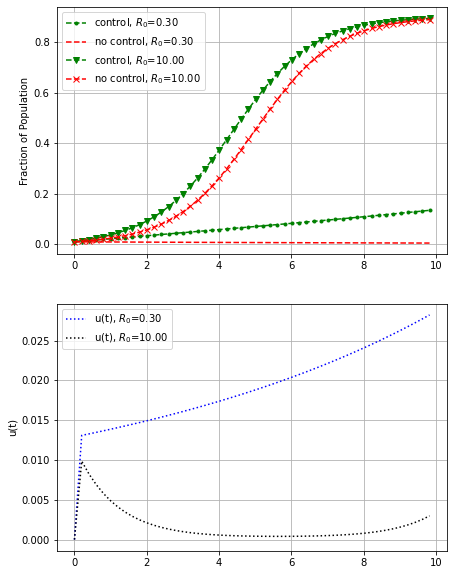

In [9]:
def graphics(ax,X_control,X_normal,U,beta_list,gamma,ns,index,control_color,normal_color,u_color,shape):
    ax[0].plot(time[::ns],X_control[index][::ns],shape[0],color=control_color,label='control, $R_0$=%0.2f'%(beta_list[index]/gamma))
    ax[0].plot(time[::ns],X_normal[index][::ns],shape[1],color=normal_color,label='no control, $R_0$=%0.2f'%(beta_list[index]/gamma))
    ax[0].legend()
    
    ax[1].plot(time[::ns],U[index][::ns],shape[2],color=u_color,label='u(t), $R_0$=%0.2f'%(beta_list[index]/gamma))
    ax[1].legend()


ns=10
fig,ax=plt.subplots(2,1,figsize=(7,10))

graphics(ax,X_control,X_normal,U,beta_list,gamma,ns,0,'g','r','b',['--.','--',':'])
graphics(ax,X_control,X_normal,U,beta_list,gamma,ns,1,'g','r','black',['--v','--x',':'])
ax[0].grid()
ax[0].set_ylabel('Fraction of Population')
ax[1].grid()
ax[1].set_ylabel('u(t)')
plt.show()


# SIS with time dependant beta 

In [57]:
def sis_time_dependant(t,i,beta_func,gamma):
    return beta_func(t)*(1-i)*i-gamma*i 

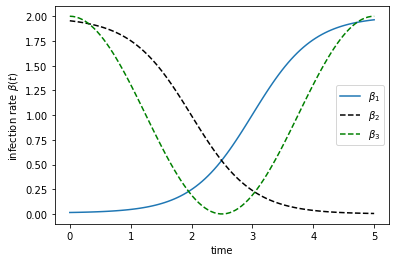

In [42]:
def beta1(t):
    return beta_m + (beta_M-beta_m)/(1+np.exp(-a1*(t-c1)))
def beta2(t):
    return (beta_M-beta_m)*(1-1/(1+np.exp(-a2*(t-c2))))
def beta3(t):
    return cm+ca*np.cos(2*np.pi*t/T)
beta_m = 0.01
beta_M = 2
a1 = 2
a2 = 2
c1 = 3
c2=2
cm=1
ca=1
T=5
t=np.linspace(0,5,100)
plt.plot(t,beta1(t), label = '$\\beta_1$')
plt.plot(t,beta2(t),'--',color='black',label = '$\\beta_2$')
plt.plot(t,beta3(t),'--',color='g',label = '$\\beta_3$')
plt.xlabel('time')
plt.ylabel('infection rate $\\beta (t)$')
plt.legend()

In [66]:
def control_sis_time_dependant(nt,nf,beta_func,gamma,umax):
    m=GEKKO()
    i0=0.01
    b=15
    nt=nt
    tf=nf
    u_max=umax
    time=np.linspace(0,tf,nt)
    m.time=time

    beta=m.Param(value=beta_func(time))
    x1=m.Var(value=i0,lb=0,ub=1)
    x2=m.Var(value=0)
    u=m.Var(value=0.035,lb=0,ub=u_max)

    p=np.zeros(nt)
    p[-1]=1
    final = m.Param(value=p)

    m.Equation(x1.dt()==-beta*x1**2+(beta-gamma-u)*x1+u)
    m.Equation(x2.dt()==b*u**2)
    
    m.Obj(-x1*final+x2*final)
    m.options.IMODE=6
    m.solve(disp=False)
    return x1.value,u.value

In [67]:
%%time
nt=500
tf=5
time=np.linspace(0,tf,nt)
gamma=0.1
u_max=0.06
i,u=control_sis_time_dependant(nt,tf,beta1,gamma,u_max)
sol=solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta1,gamma))

In [89]:
i2,u2=control_sis_time_dependant(nt,tf,beta2,gamma,u_max)
sol2=solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta2,gamma))

In [90]:
i3,u3=control_sis_time_dependant(nt,tf,beta3,gamma,u_max)
sol3=solve_ivp(sis_time_dependant,[0,tf],[0.01],t_eval=time,args=(beta3,gamma))

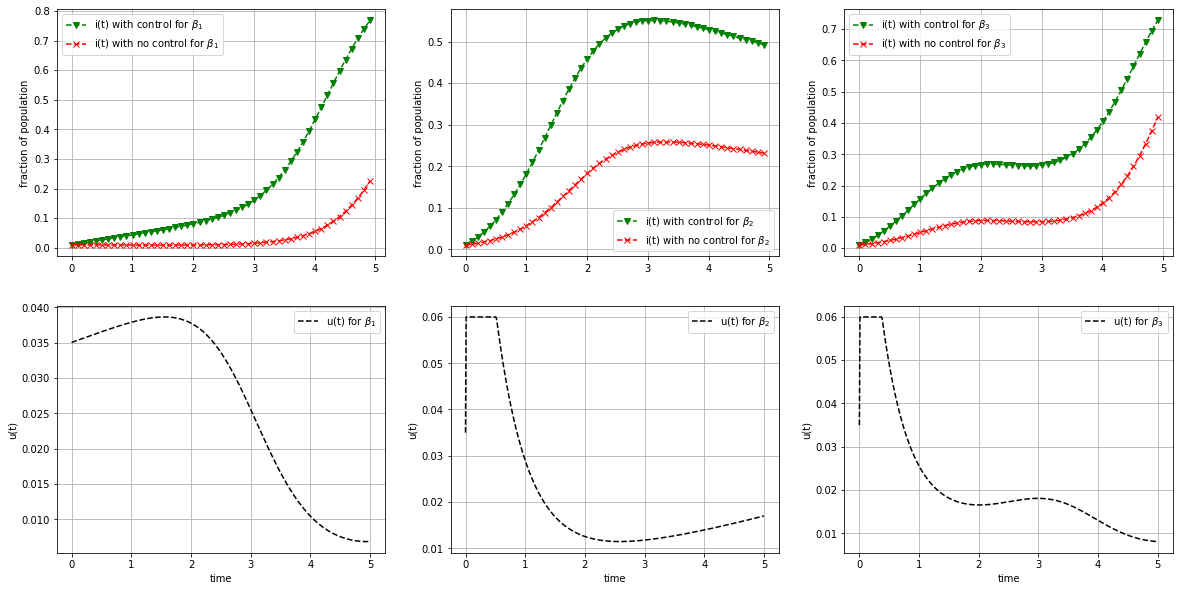

In [94]:
ns=10
fig,ax=plt.subplots(2,3,figsize=(20,10))

ax[0,0].plot(time[::ns],i[::ns],'--v',color='g',label='i(t) with control for $\\beta_1$')
ax[0,0].plot(time[::ns],sol.y[0][::ns],'--x',color='r', label='i(t) with no control for $\\beta_1$')
ax[1,0].plot(time,u,'--',color='black',label='u(t) for $\\beta_1$')
ax[0,0].legend()
ax[1,0].legend()
ax[0,0].grid()
ax[1,0].grid()
ax[0,0].set_ylabel('fraction of population')
ax[1,0].set_ylabel('u(t)')
ax[1,0].set_xlabel('time')

ax[0,1].plot(time[::ns],i2[::ns],'--v',color='g',label='i(t) with control for $\\beta_2$')
ax[0,1].plot(time[::ns],sol2.y[0][::ns],'--x',color='r', label='i(t) with no control for $\\beta_2$')
ax[1,1].plot(time,u2,'--',color='black',label='u(t) for $\\beta_2$')
ax[0,1].legend()
ax[1,1].legend()
ax[0,1].grid()
ax[1,1].grid()
ax[0,1].set_ylabel('fraction of population')
ax[1,1].set_ylabel('u(t)')
ax[1,1].set_xlabel('time')

ax[0,2].plot(time[::ns],i3[::ns],'--v',color='g',label='i(t) with control for $\\beta_3$')
ax[0,2].plot(time[::ns],sol3.y[0][::ns],'--x',color='r', label='i(t) with no control for $\\beta_3$')
ax[1,2].plot(time,u3,'--',color='black',label='u(t) for $\\beta_3$')
ax[0,2].legend()
ax[1,2].legend()
ax[0,2].grid()
ax[1,2].grid()
ax[0,2].set_ylabel('fraction of population')
ax[1,2].set_ylabel('u(t)')
ax[1,2].set_xlabel('time')

plt.show()